In [67]:
%%capture 
!pip install h2o==3.38.0.4
!pip install teemi

In [68]:
import pandas as pd
import numpy as np
import os

# 07_1_LEARN-DataAnalysisML

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/teemi/blob/main/colab_notebooks/07_1_LEARN_DataAnalysis.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

We can import the data repositoru like this: 

In [69]:
# cloning the data repo
!git clone https://github.com/hiyama341/G8H_CPR_library.git

fatal: destination path 'G8H_CPR_library' already exists and is not an empty directory.


## 0. Intro
In this study, we aim to use machine learning techniques to predict the best promoter-gene combinations. Machine learning is a powerful tool that allows us to analyze large and complex datasets, identify patterns and make predictions. We will use various machine learning algorithms through the package H2O. 

The machine learning models will be trained on the data from the experiments from[06_1_TEST_LibraryCharacterisation](../colab_notebooks/06_1_TEST_LibraryCharacterisation.ipynb), and will learn to predict the best promoter-gene combination based on the observed phenotype and genotype. This will enable us to identify the combination of genes and promoters that result in the highest level of expression or activity, without the need for additional experimentation.

Ultimately, the use of machine learning to predict the best promoter-gene combination will greatly improve the efficiency and allowing us to identify the best combination in a shorter time and with fewer resources.



In this notebook we continue the workflow by using Machine Learning to predict the best promoter:gene combinations of the remaining library that was generated in [05_1_BUILD_CombinatorialLibrary_AllStrain](../colab_notebooks/05_1_BUILD_CombinatorialLibrary_AllStrains.ipynb) and analyzed in [06_1_TEST_LibraryCharacterisation](../colab_notebooks/06_1_TEST_LibraryCharacterisation.ipynb). 

## Project overview - Use ML to predicte best promoter:gene combinations 

**Hypothesis**
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

Aim: To test the hypothesis

Tasks
1. dgRNA
2. Base strain
3. Library
4. Phenotyping
**5. Machine Learning**
   - Predict the best promoter:gene combinations


## 1. Setting up the AutoML library

In [70]:
import h2o
from h2o.automl import H2OAutoML

In [71]:
# If this doesnt work - install java. 
# Start the H2O cluster (locally)
h2o.init(ip="localhost", min_mem_size_GB=8)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,15 mins 57 secs
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,4 months and 26 days !!!
H2O_cluster_name:,H2O_from_python_lucaslevassor_15ivdv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.592 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### 1.1 Import out dataframe to h20 object

Train a model based on the target and the df

In [72]:
# Run ML with new input 
new_input_for_ml = pd.read_csv('G8H_CPR_library/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv')
new_input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp49_A01,1,2,5,1,0.271199,0.922793
1,yp49_C01,1,2,5,9,0.149626,0.509123
2,yp49_D01,2,4,7,3,0.049042,0.166871
3,yp49_E01,2,1,5,7,0.096246,0.327489
4,yp49_F01,3,3,6,1,7.365141,25.060934
...,...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0.000000,0.000000
163,yp51_D12,8,2,7,6,0.202343,0.591185
164,yp51_E12,8,1,6,10,0.153556,0.448644
165,yp50_F05,6,1,8,2,4.656777,13.391244


In [73]:
new_input_for_ml['default_rank'] = new_input_for_ml['Amt_norm'].rank()
new_input_for_ml['max_rank'] = new_input_for_ml['Amt_norm'].rank(method='max')
new_input_for_ml['NA_bottom'] = new_input_for_ml['Amt_norm'].rank(na_option='bottom')
new_input_for_ml['pct_rank'] = new_input_for_ml['Amt_norm'].rank(pct=True)
new_input_for_ml = new_input_for_ml.sort_values(by= 'Amt_norm', ascending = False)

In [74]:
new_input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm,default_rank,max_rank,NA_bottom,pct_rank
73,yp50_D03,5,2,6,3,85.210149,245.034275,167.0,167.0,167.0,1.000000
75,yp50_G03,6,2,6,5,54.362482,156.327285,166.0,166.0,166.0,0.994012
86,yp50_E05,5,1,6,8,50.194227,144.340857,165.0,165.0,165.0,0.988024
126,yp51_A02,7,2,6,1,46.443319,135.693498,164.0,164.0,164.0,0.982036
106,yp50_A09,4,2,6,3,46.710102,134.321746,163.0,163.0,163.0,0.976048
...,...,...,...,...,...,...,...,...,...,...,...
60,yp50_E01,5,3,5,7,0.000000,0.000000,30.0,59.0,30.0,0.179641
114,yp50_D11,5,4,8,6,0.000000,0.000000,30.0,59.0,30.0,0.179641
24,yp49_E05,2,3,7,8,0.000000,0.000000,30.0,59.0,30.0,0.179641
27,yp49_H05,3,3,7,10,0.000000,0.000000,30.0,59.0,30.0,0.179641


In [75]:
# Choosing which coloums to train on 
new_input_for_ml = new_input_for_ml[['Line_name','0','1','2','3','Amt_norm']]
new_input_for_ml.columns = ['Line_name','0','1','2','3','Amt_norm']

In [76]:
df_test = h2o.H2OFrame(pd.concat([new_input_for_ml], axis='columns'))
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:167
Cols:6

,Line_name,0,1,2,3,Amt_norm
type,string,int,int,int,int,real
mins,NaN,1.0,1.0,5.0,1.0,0.0
mean,NaN,4.580838323353294,2.682634730538923,6.562874251497007,5.305389221556885,15.546391286319041
maxs,NaN,8.0,4.0,8.0,10.0,245.03427469317091
sigma,NaN,2.253055064641254,1.1621014428030096,1.1696200092422187,2.836323292129,36.58610063884372
zeros,0,0,0,0,0,59
missing,0,0,0,0,0,0
0,yp50_D03,5.0,2.0,6.0,3.0,245.03427469317091
1,yp50_G03,6.0,2.0,6.0,5.0,156.3272849244192
2,yp50_E05,5.0,1.0,6.0,8.0,144.34085698560642


In [77]:
# Since the data is categorical we need to make it from numerical to categorical 
df_test['0']= df_test['0'].asfactor()
df_test['1']= df_test['1'].asfactor()
df_test['2'] = df_test['2'].asfactor()
df_test['3'] = df_test['3'].asfactor()

In [78]:
df_test.describe()

Rows:167
Cols:6

,Line_name,0,1,2,3,Amt_norm
type,string,enum,enum,enum,enum,real
mins,NaN,,,,,0.0
mean,NaN,,,,,15.546391286319041
maxs,NaN,,,,,245.03427469317091
sigma,NaN,,,,,36.58610063884372
zeros,0,,,,,59
missing,0,0,0,0,0,0
0,yp50_D03,5,2,6,3,245.03427469317091
1,yp50_G03,6,2,6,5,156.3272849244192
2,yp50_E05,5,1,6,8,144.34085698560642


Set some arguments for the autoML. 


Important here is that we dont split the dataset but rather keep the cross-validation validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split. See: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html


## NOTE: IF you don't want to run the autoML skip the next few paragraphs and go to 4

## 2. RUN automl

In [79]:
# Set the following to true if you want to run AUTOML
auto_ml = False

Here we are defining the autoML object and after we can train it

In [80]:
if auto_ml: 
    # Select the columns we want to train on
    feature_cols = ['0', '1', '2', '3']

    # Initialize H2O autoML class
    AutoML = H2OAutoML(
        max_runtime_secs=0,  # 1 hour =int(3600 * 1) , if unlimited time is wanted then set this to zero = 0
        max_models=None,  # None =  no limit
        nfolds=10,         # number of folds for k-fold cross-validation (nfolds=0 disables cross-validation)
        seed=1,            # Reproducibility
        sort_metric = "MAE",
        keep_cross_validation_predictions=True 
    )

Train a model based on the target and the df. 


It has been Commented out and saved as showed below

In [81]:
%%time
if auto_ml: 
    AutoML.train(
         x=feature_cols,
         y='Amt_norm',
         training_frame=df_test,
     ) 

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


In [82]:
print('DOOOOOOONE')

DOOOOOOONE


## 3. Processing model


In [83]:
if auto_ml: 
    ## Saving the leaderboard ids
    leaderboard = AutoML.leaderboard
    model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])

### 3.1 Saving the best model

In [84]:
if auto_ml: 

    # how to save any model
    out_path = 'G8H_CPR_library/data/09-AutoML/best_models/first_round/'
    mdl = h2o.get_model(model_ids[0])
    h2o.save_model(model=mdl, path=out_path, force=True)

### 3.2 Saving the leaderboard

In [85]:
if auto_ml: 

    # saving the leaderboard
    out_path = 'G8H_CPR_library/data/09-AutoML/leaderboards/first_round/'
    h2o.export_file(leaderboard, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

Now we want to extract the best models

In [86]:
if auto_ml: 

    df_from_h2o_object = leaderboard.as_data_frame(use_pandas=True, header=True)
    df_from_h2o_object

In [87]:
if auto_ml: 
    best_model = AutoML.get_best_model()
    best_model

### 3.4 saving the CV-holdout predictions 


In [88]:
if auto_ml: 
    # Get the predictions
    cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()

    # make the df_test to a dataframe
    as_data_frame_df_test = df_test.as_data_frame()

    # Make cv_pred to a dataframe
    as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()
    as_data_frame_CV_predictions.columns = ['cv_holdout_predictions']
    as_data_frame_CV_predictions

In [89]:
if auto_ml: 
    # merge with the test dataframe
    df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True)
    df3 = df3.sort_values(by= 'Amt_norm', ascending= False)
    df3 = df3.reset_index()
    df3['ranked_pct'] = df3['Amt_norm'].rank(pct= True)
    df3['cv_holdout_predictions_ranked_pct'] = df3['cv_holdout_predictions'].rank(pct= True)

In [90]:
if auto_ml: 
    # save it to the folder
    df3.to_csv('G8H_CPR_library/data/09-AutoML/cv_holdout_predictions/first_round/cv_holdout_predictions.csv', index=False)
    df3  = df3[['Line_name', '0', '1', '2', '3', 'Amt_norm','cv_holdout_predictions', 'ranked_pct','cv_holdout_predictions_ranked_pct']]

## 4. Importing the best model

### 4.1 Importing the leaderboard

In [91]:
models_path = "G8H_CPR_library/data/09-AutoML/leaderboards/first_round/"

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))
lb

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,mae,rmse,mse,rmsle,mean_residual_deviance
DeepLearning_grid_1_AutoML_1_20230201_104644_model_58,8.03735,18.1042,327.762,nan,327.762
DeepLearning_grid_1_AutoML_1_20230201_104644_model_92,8.04238,17.7241,314.144,nan,314.144
DeepLearning_grid_1_AutoML_1_20230201_104644_model_13,8.15243,17.6159,310.32,nan,310.32
StackedEnsemble_BestOfFamily_6_AutoML_1_20230201_104644,8.28665,18.256,333.28,nan,333.28
StackedEnsemble_Best1000_1_AutoML_1_20230201_104644,8.3251,18.2275,332.241,nan,332.241
StackedEnsemble_BestOfFamily_5_AutoML_1_20230201_104644,8.33928,20.2976,411.993,nan,411.993
StackedEnsemble_BestOfFamily_4_AutoML_1_20230201_104644,8.36795,17.9179,321.05,nan,321.05
DeepLearning_grid_1_AutoML_1_20230201_104644_model_68,8.41505,17.406,302.968,nan,302.968
DeepLearning_grid_1_AutoML_1_20230201_104644_model_49,8.4392,17.4249,303.628,nan,303.628
DeepLearning_grid_1_AutoML_1_20230201_104644_model_44,8.49537,19.5019,380.325,nan,380.325


In [92]:
best_model = h2o.load_model("G8H_CPR_library/data/09-AutoML/best_models/first_round/"+lb[0,0]) 

In [93]:
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20230201_104644_model_58


Status of Neuron Layers: predicting Amt_norm, regression, gaussian distribution, Quadratic loss, 1,601 weights/biases, 22.4 KB, 1,671,670 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms              momentum    mean_weight           weight_rms          mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  --------------------  ----------  --------------------  ------------------  --------------------  -----------------------
    1        30       Input             0.0
    2        50       RectifierDropout  50.0       0.0   0.0   0.14153930723818484    0.3476378917694092    0.0         -0.07521158719650703  0.4997161626815796  -0.26781051759262686  0.2556114196777344
    3        1        Linear                       0.0   0.0   0.0009726229096122551  0.003230801783502102  0.0         -0.08209915764629841  0.4046359062194824  -0.39262398789470215  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 37.068706952172235
RMSE: 6.088407587552942
MAE: 2.728627138605333
RMSLE: 0.5554433994240296
Mean Residual Deviance: 37.068706952172235

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 327.7617727264971
RMSE: 18.104192131285426
MAE: 8.037346736078618
RMSLE: NaN
Mean Residual Deviance: 327.7617727264971

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     8.03034   3.95942    14.4279       6.64181       6.37023       5.20376       4.35421       6.90536       13.4793       12.8442       6.02368       4.05291
mean_residual_deviance  328.08    351.632    856.122       171.223       129.248       62.7214       54.6352       199.073       770.469       868.041       117.868       51.3946
mse                     328.08    351.632    856.122       171.223       129.248       62.7214       54.6352       199.073       770.469       868.041       117.868       51.3946
r2                      0.729258  0.310538   0.754488      0.891373      0.905812      0.949212      0.954273      0.819721      0.193679      0.111321      0.827843      0.884858
residual_deviance       328.08    351.632    856.122       171.223       129.248       62.7214       54.6352       199.073       770.469       868.041       117.868       51.3946
rmse                    15.838    9.26393    29.2596       13.0852       11.3687       7.91969       7.39156       14.1093       27.7573       29.4625       10.8567       7.169
rmsle                   0.955662  0.0725219  nan           1.00694       0.904381      nan           nan           nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration           training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2
--  -------------------  -----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------
    2023-02-01 11:18:11  0.000 sec                            0         0             0            nan              nan                  nan             nan
    2023-02-01 11:18:11  18 min 22.700 sec  334000 obs/sec    10        1             1670         33.8833          1148.08              17.0072         0.134185
    2023-02-01 11:18:13  18 min 24.458 sec  951434 obs/sec    10010     1001          1.67167e+06  

### 4.1 Investigate the best model - Cross-validation holdout predictions

Get the cross validation predictions

In [94]:
df3 = pd.read_csv('G8H_CPR_library/data/09-AutoML/cv_holdout_predictions/first_round/cv_holdout_predictions.csv')
df3

,Line_name,0,1,2,3,Amt_norm,cv_holdout_predictions,ranked_pct,cv_holdout_predictions_ranked_pct
0,yp50_D03,5,2,6,3,245,182.026346,1.000000,0.994012
1,yp50_G03,6,2,6,5,156,126.638507,0.994012,0.982036
2,yp50_E05,5,1,6,8,144,108.859392,0.988024,0.958084
3,yp51_A02,7,2,6,1,135,116.967918,0.982036,0.970060
4,yp50_A09,4,2,6,3,134,112.586929,0.976048,0.964072
...,...,...,...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0,0.465466,0.287425,0.326347
163,yp51_D12,8,2,7,6,0,-4.656575,0.287425,0.029940
164,yp51_E12,8,1,6,10,0,-20.376793,0.287425,0.005988
165,yp49_D01,2,4,7,3,0,0.592112,0.287425,0.374251


#### Barplot of production vs prediction 

In [95]:
from teemi.learn.plotting import bar_plot_w_hue

In [133]:
%%capture
# initialize
ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']
ds2 = df3[['Line_name', 'cv_holdout_predictions']]
ds2.columns = ['Line_name', 'strict']

# add category
ds2['category'] = 'cv_holdout_predictions'
ds1['category'] = 'strictosidine'
dss = pd.concat([ds1, ds2])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


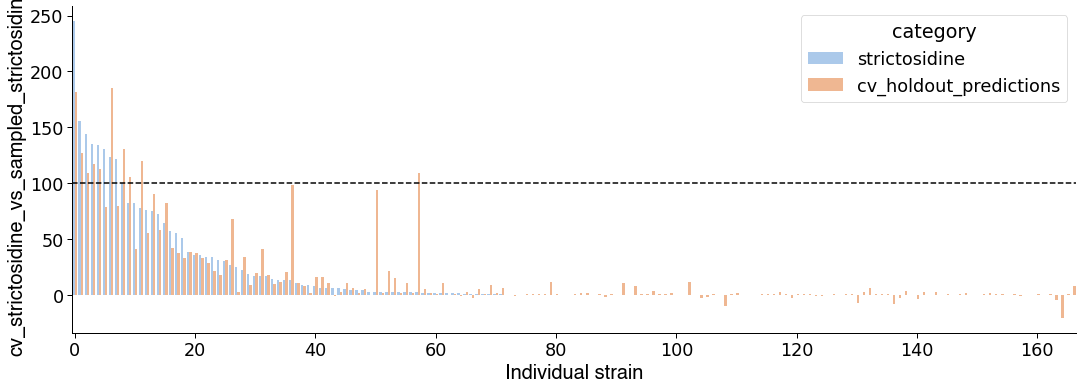

In [135]:
bar_plot_w_hue(dss, 'Line_name', 'strict', 
               path = 'G8H_CPR_library/data/10-plots/07_1_LEARN_DataAnalysis/Prediction of the sampled library_ranked',
               palette = 'pastel',
             y_label= 'cv_strictosidine_vs_sampled_strictosidine', 
            x_label = 'Individual strain',
              size_height= 6, 
              size_length = 18)

#### Ranking production and correlation plots 

In [98]:
df3['norm_strict_measured_rank_pct']= df3['Amt_norm'].rank(pct=True)
df3['cv_holdout_predictions_rank_pct'] = df3['cv_holdout_predictions'].rank(pct=True)
df3.to_csv('G8H_CPR_library/data/09-AutoML/all_predictions/first_round/input_for_ml_1st_iteration_w_predictions_and_ranking_2701.csv',index=False)
df3

,Line_name,0,1,2,3,Amt_norm,cv_holdout_predictions,ranked_pct,cv_holdout_predictions_ranked_pct,norm_strict_measured_rank_pct,cv_holdout_predictions_rank_pct
0,yp50_D03,5,2,6,3,245,182.026346,1.000000,0.994012,1.000000,0.994012
1,yp50_G03,6,2,6,5,156,126.638507,0.994012,0.982036,0.994012,0.982036
2,yp50_E05,5,1,6,8,144,108.859392,0.988024,0.958084,0.988024,0.958084
3,yp51_A02,7,2,6,1,135,116.967918,0.982036,0.970060,0.982036,0.970060
4,yp50_A09,4,2,6,3,134,112.586929,0.976048,0.964072,0.976048,0.964072
...,...,...,...,...,...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0,0.465466,0.287425,0.326347,0.287425,0.326347
163,yp51_D12,8,2,7,6,0,-4.656575,0.287425,0.029940,0.287425,0.029940
164,yp51_E12,8,1,6,10,0,-20.376793,0.287425,0.005988,0.287425,0.005988
165,yp49_D01,2,4,7,3,0,0.592112,0.287425,0.374251,0.287425,0.374251


In [99]:
from teemi.learn.plotting import correlation_plot
correlation_plot

<function teemi.learn.plotting.correlation_plot(dataframe, x: str, y: str, save_pdf: bool = True, path: str = '', title: str = '', size_height: int = 10, size_length: int = 10, y_axis_range: list = [0, 1], x_axis_range: list = [0, 1]) -> None>

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


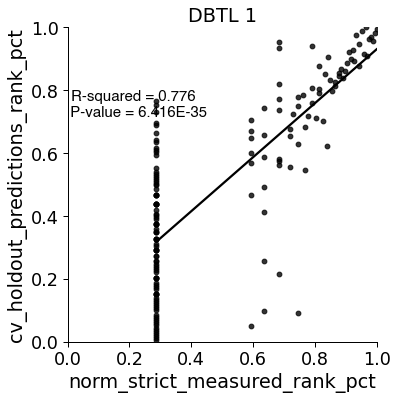

In [100]:
correlation_plot(df3,"norm_strict_measured_rank_pct","cv_holdout_predictions_rank_pct", save_pdf = True , 
                 path ='G8H_CPR_library/data/10-plots/07_1_LEARN_DataAnalysis/corr_plot_rank',
                 title = 'DBTL 1',
                 size_height= 5, 
                 size_length = 5, 
                 y_axis_range = [0,1],
                 x_axis_range = [0,1])

## 5. Clean up data on the remaining library of combinations of genotypes

In [101]:
import numpy as np

In [102]:
all_genotypes = pd.read_csv('G8H_CPR_library/data/03-strain_sequences/systematic_names_of_all_strains/systematic_names_on_all_combinations.csv')
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))
all_genotypes_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0,1,2,3
1,1,5,1
1,1,5,2
1,1,5,3
1,1,5,4
1,1,5,5
1,1,5,6
1,1,5,7
1,1,5,8
1,1,5,9
1,1,5,10


In [103]:
input_fixed = new_input_for_ml[['0','1','2','3']]
input_fixed

,0,1,2,3
73,5,2,6,3
75,6,2,6,5
86,5,1,6,8
126,7,2,6,1
106,4,2,6,3
...,...,...,...,...
60,5,3,5,7
114,5,4,8,6
24,2,3,7,8
27,3,3,7,10


Getting rid of the genotypes we have already tested:

In [104]:
df_diff = all_genotypes[~all_genotypes.apply(tuple,1).isin(input_fixed.apply(tuple,1))]
df_diff

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
3,1,1,5,4
4,1,1,5,5
6,1,1,5,7
...,...,...,...,...
1275,8,4,8,6
1276,8,4,8,7
1277,8,4,8,8
1278,8,4,8,9


In [105]:
# make the diff into a df 
all_genotypes_df = h2o.H2OFrame(pd.concat([df_diff], axis='columns'))
all_genotypes_df['0']= all_genotypes_df['0'].asfactor()
all_genotypes_df['1']= all_genotypes_df['1'].asfactor()
all_genotypes_df['2'] = all_genotypes_df['2'].asfactor()
all_genotypes_df['3'] = all_genotypes_df['3'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## 6. Predict the  phenotypes from the whole library

In [106]:
predicted = best_model.predict(all_genotypes_df)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [107]:
len(predicted)

1121

In [108]:
predicted_norm = predicted.as_data_frame()
predicted_norm.head()

,predict
0,0.627268
1,0.893352
2,0.882574
3,0.019437
4,0.750782


In [109]:
# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
df_diff['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = df_diff.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1470/105107836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['predicted_norm_strict'] = predicted_list


,0,1,2,3,predicted_norm_strict
690,5,2,6,1,189.410583
697,5,2,6,8,184.930663
691,5,2,6,2,183.786563
852,6,2,6,3,179.451003
682,5,2,5,3,177.130989
...,...,...,...,...,...
176,2,1,6,7,-19.791379
13,1,1,6,4,-22.477388
975,7,1,6,6,-27.497594
976,7,1,6,7,-32.604113


If we want the names on the genotypes we can do the following: 

In [110]:
g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

In [111]:
df_with_genotypes = pd.DataFrame(list_of_lists )
df_with_genotypes = df_with_genotypes.T
df_with_genotypes.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
df_with_genotypes.head(10)

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cro,189.410583
1,Smus,ENO2,TPI1,Cac,184.930663
2,Smus,ENO2,TPI1,Aan,183.786563
3,Rsep,ENO2,TPI1,Ara,179.451003
4,Smus,ENO2,CCW12,Ara,177.130989
5,Rsep,ENO2,TPI1,Cro,170.566436
6,Smus,ENO2,TPI1,Rse,164.283399
7,Rsep,ENO2,TPI1,Cac,164.036205
8,Rsep,ENO2,CCW12,Ara,159.52189
9,Rsep,ENO2,TPI1,Aan,158.31551


In [112]:
from teemi.learn.plotting import bar_plot
bar_plot

<function teemi.learn.plotting.bar_plot(x: list, y: list, error_bar: list = None, horisontal_line=True, save_pdf=True, color='white', path='', title=None, x_label=None, y_label=None, size_height: int = 25, size_length: int = 15) -> None>

#### 6.1 Plot of predicted strictosidine production across all promoter:homolog combinations

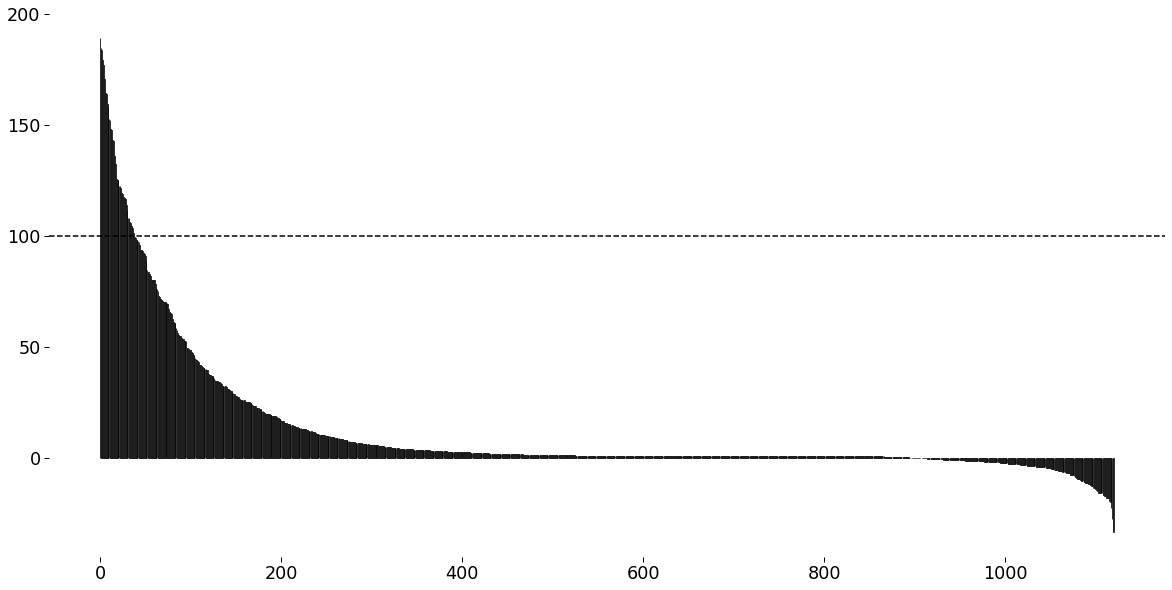

In [113]:
x = list(df_with_genotypes.index)
y = list(df_with_genotypes['Predicted_strict_production'])

bar_plot(x, y, path = 'G8H_CPR_library/data/10-plots/07_1_LEARN_DataAnalysis/barplot_predicting_remaining_best_combinations_2701',
        size_height =  10, 
         size_length = 20)

In [114]:
df_with_genotypes

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cro,189.410583
1,Smus,ENO2,TPI1,Cac,184.930663
2,Smus,ENO2,TPI1,Aan,183.786563
3,Rsep,ENO2,TPI1,Ara,179.451003
4,Smus,ENO2,CCW12,Ara,177.130989
...,...,...,...,...,...
1116,Opum,CYC1,TPI1,Ani,-19.791379
1117,Cacu,CYC1,TPI1,Clo,-22.477388
1118,Oeu,CYC1,TPI1,Ahu,-27.497594
1119,Oeu,CYC1,TPI1,Ani,-32.604113


Lets save the dataframes into csv files

## 7. Top 20 predicted producers of the unseen library

Lets look at the file generated first from one of the first models. 

In [115]:
df_with_genotypes = pd.read_csv('G8H_CPR_library/data/09-AutoML/all_predictions/first_round/top_ML_predicted_after_first_DBTL_merged_analytics.csv')

In [116]:
df_with_genotypes

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cro,189.410583
1,Smus,ENO2,TPI1,Cac,184.930663
2,Smus,ENO2,TPI1,Aan,183.786563
3,Rsep,ENO2,TPI1,Ara,179.451003
4,Smus,ENO2,CCW12,Ara,177.130989
...,...,...,...,...,...
1116,Opum,CYC1,TPI1,Ani,-19.791379
1117,Cacu,CYC1,TPI1,Clo,-22.477388
1118,Oeu,CYC1,TPI1,Ahu,-27.497594
1119,Oeu,CYC1,TPI1,Ani,-32.604113


Adding unique names 

In [117]:
df_with_genotypes['names'] = df_with_genotypes['G8H']+'-' +df_with_genotypes['pG8H']+ '_'+ df_with_genotypes['pCPR']+'_'+df_with_genotypes['CPR']

In [118]:
from teemi.learn.plotting import horisontal_bar_plot

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


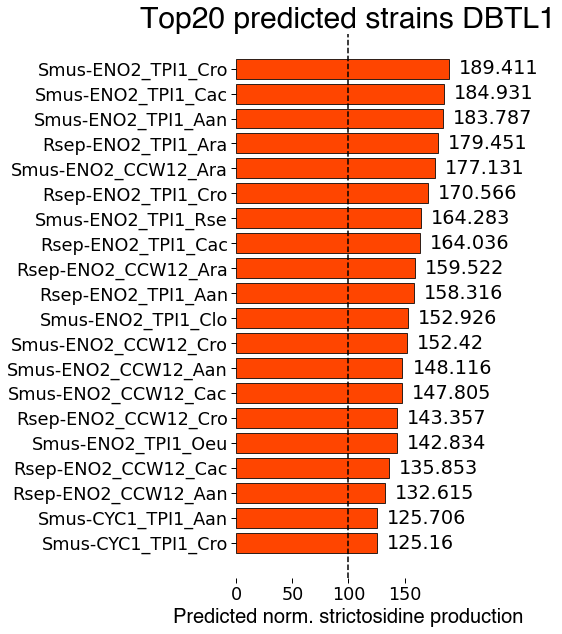

In [119]:
# Plotting top 20 strains
x_axis = list(df_with_genotypes['names'])[:20][::-1]
y_axis = list(df_with_genotypes['Predicted_strict_production'])[:20][::-1]

horisontal_bar_plot(x_axis,y_axis, path = 'G8H_CPR_library/data/10-plots/07_1_LEARN_DataAnalysis/Top20 predicted strains DBTL1', 
                    title = 'Top20 predicted strains DBTL1', 
                    size_height=4, 
                   color = '#ff4500',
                   size_length=10, 
                   x_label='Predicted norm. strictosidine production', 
                   legend = False)

### 7.1 How many genotypes are predicted to produce more than the control strain?

In [120]:
over_100_strict_production = df_with_genotypes[df_with_genotypes['Predicted_strict_production'] >= 100 ]
print(f"{len(over_100_strict_production)} strains out of {len(df_with_genotypes)} are predicted to produce strictosidine over the normalized value")
print(f"Out of the remaining theoretical space these constitute : {(len(over_100_strict_production)/len(df_with_genotypes))*100}")

38 strains out of 1121 are predicted to produce strictosidine over the normalized value
Out of the remaining theoretical space these constitute : 3.389830508474576


## 8. Learning curve on partitioned data

In [121]:
from teemi.learn.auto_ml import autoML_on_partitioned_data

In [122]:
new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
73,yp50_D03,5,2,6,3,245.034275
75,yp50_G03,6,2,6,5,156.327285
86,yp50_E05,5,1,6,8,144.340857
126,yp51_A02,7,2,6,1,135.693498
106,yp50_A09,4,2,6,3,134.321746
...,...,...,...,...,...,...
60,yp50_E01,5,3,5,7,0.000000
114,yp50_D11,5,4,8,6,0.000000
24,yp49_E05,2,3,7,8,0.000000
27,yp49_H05,3,3,7,10,0.000000


The following function takes ~30 hours to run on my macbook pro M1. ¨


1. It trains models on partitions of the data meaning that it splits the data into equally sized partitions. 
2. Then it shuffles the data and trains models on these partitions. 
3. Finally it creates a csv file with the MAE for the best model, CV MAE and CV Standard deviation and model name. 

Cross-validation metric nfold = 5 was chosen to not get better predictions on the smallest partion ~60 datapoints. 

In [123]:
run_ML = False
if run_ML: 
    feature_cols = ['0', '1', '2', '3']
    training_column = 'Amt_norm'

    # Training 3 partitions 10 times - the function is set to nfold = 10  by default. Each time 
    for i in range(0,10): 
        # shuffle dataset each time we make a dataframe
        new_input_for_ml = new_input_for_ml.sample(frac=1, random_state= i).reset_index(drop=True) # Random state sets a seed on the shuffeling

        autoML_on_partitioned_data(feature_cols,                    # Which features to use for training
                                training_column,                    # Which colum to use for training
                                 new_input_for_ml,                  # Input data to train on
                                 training_time=0, 
                                 partitions = 3,                    # we get partitions that are around 60
                                 nfold= 5,
                                 path = 'G8H_CPR_library/data/09-AutoML/data_from_learning_curve/first_round/nfold_5/')

### 8.1 - visualizing learning curve

In [124]:
import os

# folder path
dir_path = 'G8H_CPR_library/data/09-AutoML/data_from_learning_curve/first_round/nfold_5/'

# list file and directories
res = os.listdir(dir_path)
print(len(res))
res

10


['2023_03_31_06:09_ml_models_running_over_partioned_data.csv',
 '2023_03_31_00:13_ml_models_running_over_partioned_data.csv',
 '2023_03_31_03:09_ml_models_running_over_partioned_data.csv',
 '2023_03_29_19:36_ml_models_running_over_partioned_data.csv',
 '2023_03_29_16:38_ml_models_running_over_partioned_data.csv',
 '2023_03_30_18:16_ml_models_running_over_partioned_data.csv',
 '2023_03_30_12:19_ml_models_running_over_partioned_data.csv',
 '2023_03_30_15:16_ml_models_running_over_partioned_data.csv',
 '2023_03_29_22:37_ml_models_running_over_partioned_data.csv',
 '2023_03_30_21:15_ml_models_running_over_partioned_data.csv']

In [125]:
lst_of_pd_dataframes = []
for ml_partitioned in res:
    if ml_partitioned.endswith('.csv'):
        lst_of_pd_dataframes.append(pd.read_csv(dir_path+ml_partitioned))

Lets retrieve the data 

In [126]:
dfs = [df.set_index('Unnamed: 0') for df in lst_of_pd_dataframes]
concated = pd.concat(dfs, axis=1)
concated

,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,...,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
56,12.914165,15.894010,13.641443,XGBoost_grid_1_AutoML_38_20230331_30921_model_131,2.856489,11.437623,9.360228,DeepLearning_grid_3_AutoML_26_20230330_211529_...,12.151139,16.884157,...,1.663112,XGBoost_lr_search_selection_AutoML_8_20230330_...,10.023683,14.959974,3.617987,StackedEnsemble_AllModels_5_AutoML_7_20230329_...,1.880219,9.374698,3.092595,XGBoost_lr_search_selection_AutoML_20_20230330...
112,4.488660,10.632452,2.409134,StackedEnsemble_BestOfFamily_7_AutoML_40_20230...,0.309657,7.910044,4.011237,XGBoost_lr_search_selection_AutoML_28_20230330...,10.553681,13.069860,...,2.733297,XGBoost_grid_1_AutoML_10_20230330_131918_model...,1.244773,10.388973,4.047510,GBM_grid_1_AutoML_8_20230329_203654_model_300,4.362237,10.403327,5.259947,XGBoost_lr_search_selection_AutoML_22_20230330...
167,1.889398,10.122628,5.822503,GBM_lr_annealing_selection_AutoML_42_20230331_...,4.128180,11.565599,2.924687,XGBoost_lr_search_selection_AutoML_30_20230330...,2.982598,11.778864,...,3.175333,XGBoost_lr_search_selection_AutoML_12_20230330...,1.089678,8.359665,1.795347,XGBoost_grid_1_AutoML_9_20230329_213702_model_98,5.585249,10.102481,1.937091,XGBoost_grid_1_AutoML_24_20230330_201520_model...


In [127]:
# test results
test_results = concated[['0']]
test_results['mean'] = test_results.mean(axis=1)
test_results['std'] = test_results.std(axis=1)
test_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1470/934127194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['mean'] = test_results.mean(axis=1)
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1470/934127194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['std'] = test_results.std(axis=1)


,0,0,0,0,0,0,0,0,0,0,mean,std
Unnamed: 0,,,,,,,,,,,,
56,12.914165,2.856489,12.151139,5.290319,3.436689,0.083115,0.828466,0.839082,10.023683,1.880219,5.030337,4.634087
112,4.488660,0.309657,10.553681,4.581212,5.198155,6.839329,4.034227,1.221148,1.244773,4.362237,4.283308,2.851076
167,1.889398,4.128180,2.982598,5.464998,5.586957,2.183173,1.082308,4.497073,1.089678,5.585249,3.448961,1.737189


In [128]:
# Cross-validated mean MAE
cross_validated_results = concated[['CV_mean_MAE']]
cross_validated_results['mean'] = cross_validated_results.mean(axis=1)
cross_validated_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1470/994047639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results['mean'] = cross_validated_results.mean(axis=1)


,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,mean
Unnamed: 0,,,,,,,,,,,
56,15.894010,11.437623,16.884157,10.446466,8.468381,10.668349,9.744218,7.024940,14.959974,9.374698,11.490282
112,10.632452,7.910044,13.069860,11.544723,9.641504,10.743375,10.048363,8.902894,10.388973,10.403327,10.328552
167,10.122628,11.565599,11.778864,11.174342,11.833032,10.537651,9.587582,9.907881,8.359665,10.102481,10.496972


In [129]:
# Cross-validated mean SD
cross_validated_results_sd = concated[['CV_SD_MAE']]
cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)
cross_validated_results_sd

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1470/3504483626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)


,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,mean
Unnamed: 0,,,,,,,,,,,
56,13.641443,9.360228,13.855289,10.108312,3.072893,7.248753,4.637295,1.663112,3.617987,3.092595,7.029791
112,2.409134,4.011237,7.169513,5.138218,4.533426,3.767427,5.341413,2.733297,4.047510,5.259947,4.441112
167,5.822503,2.924687,4.569194,2.546307,4.015618,3.449665,2.708871,3.175333,1.795347,1.937091,3.294462


In [130]:
from teemi.learn.plotting import plot_ml_learning_curve

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


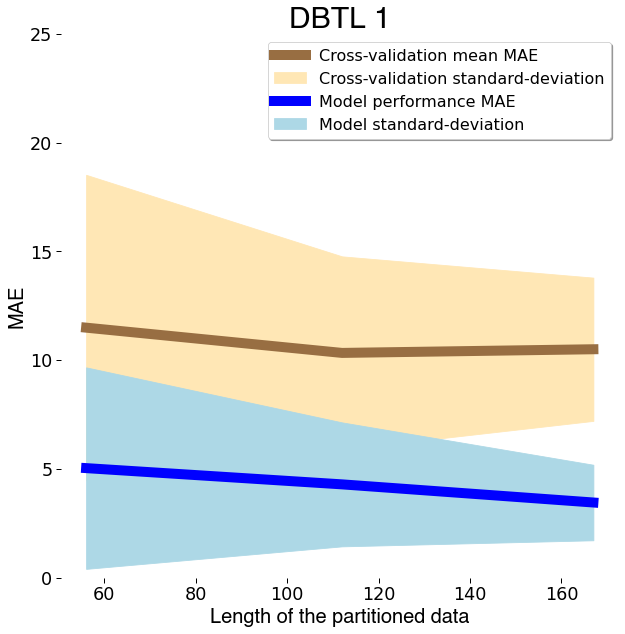

In [131]:
# CV
x = list(cross_validated_results.index)
y = list(cross_validated_results['mean'])
sd =  list(cross_validated_results_sd['mean'])

# model_performance
y1 = list(test_results['mean'])
sd1 = np.array(list(test_results['std']))


plot_ml_learning_curve(x, y1, y,sd1,  sd, save_pdf = True ,
                       path = 'G8H_CPR_library/data/10-plots/07_1_LEARN_DataAnalysis/Learning_curve_on_partitioned_data_DBTL1_10_height_10_length', 
                             size_height = 10,
                             size_length = 10, 
                             linewidth=10, 
                             title = 'DBTL 1'
                              )

In [132]:
#h2o.shutdown()